In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset
# from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'local'

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
  root = local_root
elif location == 'google':
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  root = colab_root
elif location == 'aws':
  root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
results_path = repo_path + 'results/'
sys.path.append(repo_path)

In [5]:
# setup cell
from notebooks.viz_fns import show_image_batch, set_plt_settings
from notebooks.viz_fns import plot_accs
from notebooks.train_fns import Flatten, train_model
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier, ConvnextTransferClassifier, TransformerTransferClassifier
from notebooks.scrape_fns import get_filelist

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [6]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[10,25,50])
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [7]:
# load image scores
filename = 'images_spec_realtree_pcts.csv'
realtree_likelihood = np.loadtxt(data_path + filename).astype(float).tolist()

# subset based on threshold
threshold=0.55
flag = np.array(realtree_likelihood) > threshold
realtree_idxs = (np.arange(0, len(flag))[flag]).tolist()
print(f'\nimages meeting threshold ({threshold}): {sum(flag)} ({sum(flag)/len(flag):0.2%})')
# realtree_idxs = None

# make dataloaders with the subset data
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=1)


images meeting threshold (0.55): 27882 (84.92%)
dataloader sizes: {'all': 27882, 'train': 18819, 'validate': 6274, 'test': 2789, 'sampler': 4}


# Baseline models

In [8]:
# define small loader for testing
random_idxs = np.random.choice(range(len(treeds)), 50).tolist()
small_loaders, small_ds_sizes = make_dataloaders(
    dataset=treeds, subset=random_idxs, test_split=0.01, val_split=0.25, 
    sampleN=4, batch_size=10, seed=1)

# setup testing parameters
loaders = small_loaders
sizes = small_ds_sizes
# loaders = dataloaders
# sizes = ds_sizes

# define some constants
num_epochs = 2
lr_decay_step_size = 4

print(f'Performance of random chance:', 1 / len(class_names))

dataloader sizes: {'all': 50, 'train': 36, 'validate': 13, 'test': 1, 'sampler': 4}
Performance of random chance: 0.14285714285714285


## Softmax

validate epoch: [2/2] Loss: -0.0038 ACC@1: 0.00%: 100%|██████████| 2/2 [00:07<00:00,  3.83s/it]



Returning best model, with validation accuracy 0.0


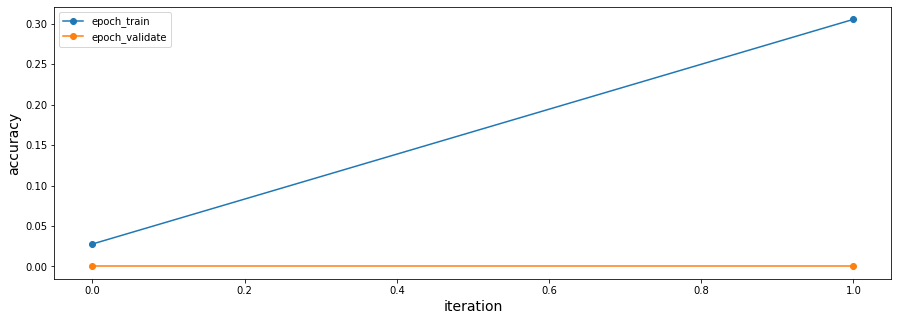

In [ ]:
model_name = 'SoftmaxClassifier'

# define the model, optimizer, and scheduler (for lr decay)
model_sm = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names)),
    nn.Softmax(dim=1)
    ).to(device)
optimizer = optim.SGD(model_sm.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=0.1) # lr decay
criterion = nn.NLLLoss()
acc_sm = train_model(model_sm, criterion, optimizer, schedlr,
                             loaders, sizes, device, num_epochs)
plot_accs({key: acc_sm[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
# MODEL
torch.save(model_sm.state_dict(), model_path + f'{model_name}.pt')
# RESULTS
filename = f'acc_{model_name}.csv'
epoch_results = pd.DataFrame({key: torch.Tensor(acc_sm[key]) for key in ['epoch_train', 'epoch_validate']})
epoch_results.to_csv(results_path + filename)

## Hinge loss (SVM)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [10].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: An output with one or more elements was resized since it had shape [10], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it


Returning best model, with validation accuracy 0.23076923076923078


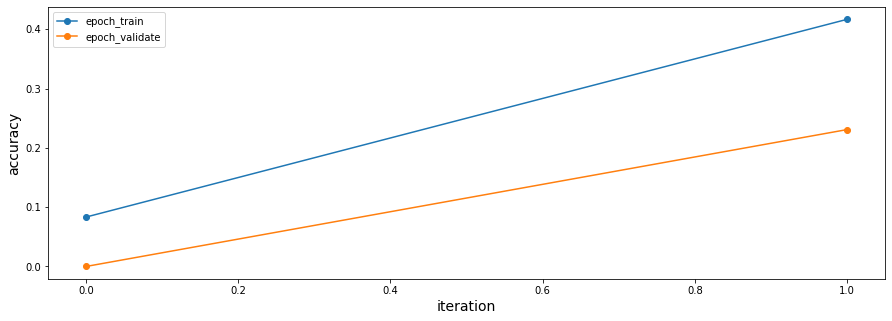

In [ ]:
model_name = 'HingeClassifier'

# define model
model_mh = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names))
    ).to(device)
optimizer = optim.SGD(model_mh.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.MultiMarginLoss()
# run model and plot results
acc_mh = train_model(model_mh, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_mh[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
# MODEL
torch.save(model_mh.state_dict(), model_path + f'{model_name}.pt')
# RESULTS
filename = f'acc_{model_name}.csv'
epoch_results = pd.DataFrame({key: torch.Tensor(acc_mh[key]) for key in ['epoch_train', 'epoch_validate']})
epoch_results.to_csv(results_path + filename)

## 2-layer fully connected net

validate epoch: [2/2] Loss: 2.7731 ACC@1: 15.38%: 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]



Returning best model, with validation accuracy 0.23076923076923078


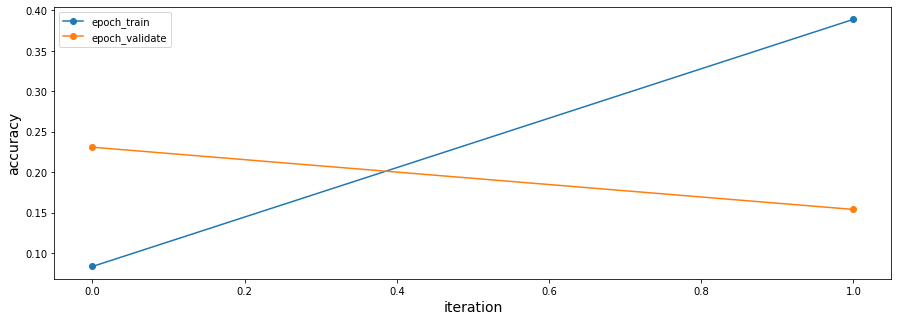

In [ ]:
model_name = 'TwoLayerFC'

# define model
hidden_layer_size = 500
model_fc = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, len(class_names))
    ).to(device)
optimizer = optim.SGD(model_fc.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
# run model and plot results
acc_fc = train_model(model_fc, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_fc[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
# MODEL
torch.save(model_fc.state_dict(), model_path + f'{model_name}.pt')
# RESULTS
filename = f'acc_{model_name}.csv'
epoch_results = pd.DataFrame({key: torch.Tensor(acc_fc[key]) for key in ['epoch_train', 'epoch_validate']})
epoch_results.to_csv(results_path + filename)

## 3-layer ConvNet

validate epoch: [2/2] Loss: 2.0791 ACC@1: 15.38%: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Returning best model, with validation accuracy 0.15384615384615385


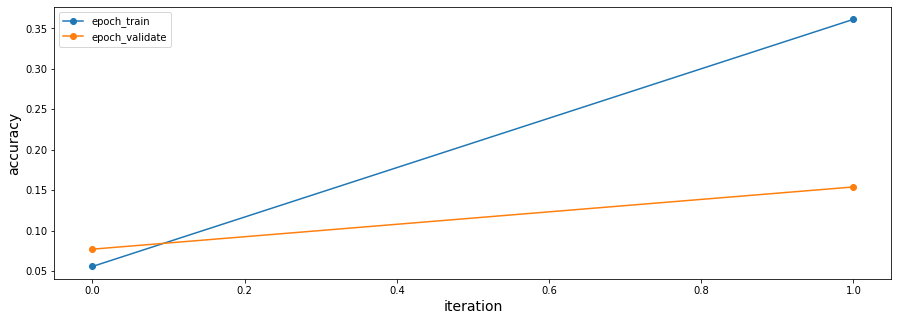

In [ ]:
model_name = 'ThreeLayerCNN'

# define model
channel_1 = 32
channel_2 = 16
# padding chosen to preserve original H/W dimensions
model_cn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel_1, kernel_size=5, padding=(5 - 1)//2),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, padding=(3 - 1)//2),
    nn.ReLU(), 
    Flatten(),
    nn.Linear(channel_2*IMAGE_DIM*IMAGE_DIM, len(class_names))
    ).to(device)
optimizer_cn = optim.SGD(model_cn.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_cn = lr_scheduler.StepLR(optimizer_cn, step_size=2, gamma=0.1) # lr decay
criterion_cn = nn.CrossEntropyLoss()
# run model and plot results
acc_cn = train_model(model_cn, criterion_cn, optimizer_cn, schedlr_cn,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_cn[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
# MODEL
torch.save(model_cn.state_dict(), model_path + f'{model_name}.pt')
# RESULTS
filename = f'acc_{model_name}.csv'
epoch_results = pd.DataFrame({key: torch.Tensor(acc_cn[key]) for key in ['epoch_train', 'epoch_validate']})
epoch_results.to_csv(results_path + filename)

## Summarize

In [ ]:
key = 'epoch_validate'

baseline_results = {
    'softmax': max(acc_sm[key]),
    'svm': max(acc_mh[key]),
    '2layer_fc': max(acc_fc[key]),
    '3layer_cnn':max(acc_cn[key])
}
baseline_results

{'2layer_fc': tensor(0.0769, dtype=torch.float64),
 '3layer_cnn': tensor(0.1538, dtype=torch.float64),
 'softmax': tensor(0., dtype=torch.float64),
 'svm': tensor(0.2308, dtype=torch.float64)}

# Transfer learning models

## Training only the last fully connected layer

### Resnet

validate epoch: [2/2] Loss: 2.0043 ACC@1: 7.69%: 100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Returning best model, with validation accuracy 0.07692307692307693


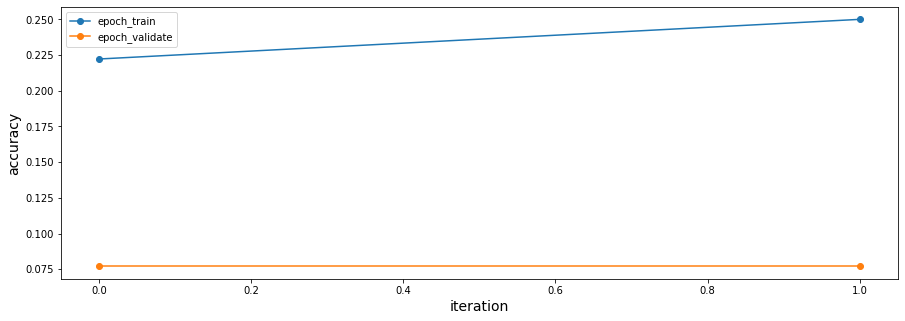

In [ ]:
model_name = 'ResnetClassifierFC'

m_resnet = ResnetTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
m_resnet = m_resnet.to(device)
optimizer = optim.SGD(m_resnet.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_res = train_model(m_resnet, criterion, optimizer, schedlr,
                        loaders, sizes, device, num_epochs)
plot_accs({key: acc_res[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
# MODEL
torch.save(m_resnet.state_dict(), model_path + f'{model_name}.pt')
# RESULTS
filename = f'acc_{model_name}.csv'
epoch_results = pd.DataFrame({key: torch.Tensor(acc_res[key]) for key in ['epoch_train', 'epoch_validate']})
epoch_results.to_csv(results_path + filename)

### Convnext

In [39]:
from torchvision import models
vit = models.resnet50(pretrained=True)

In [38]:
vit.features

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (1): Sequential(
    (0): CNBlock(
      (block): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=96, out_features=384, bias=True)
        (4): GELU()
        (5): Linear(in_features=384, out_features=96, bias=True)
        (6): Permute()
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): CNBlock(
      (block): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=96, out_features=384, bias=True)
        (4): GELU()
        (5): Linear(in_features=384, 

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

validate epoch: [2/2] Loss: 1.9349 ACC@1: 15.38%: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Returning best model, with validation accuracy 0.15384615384615385


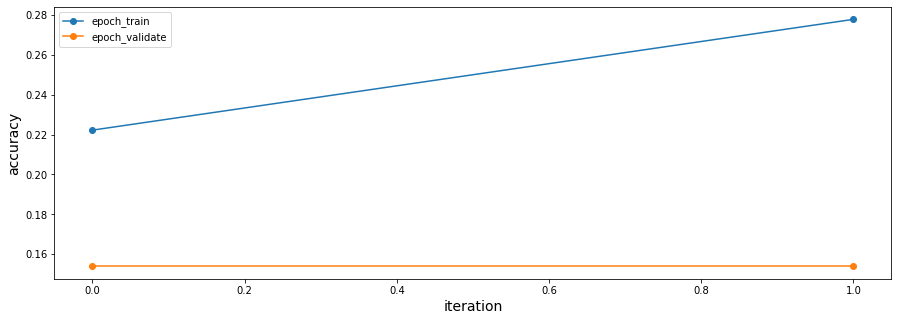

In [ ]:
model_name = 'ConvNextClassifierFC'

m_convnext = ConvnextTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
m_convnext = m_convnext.to(device)
optimizer = optim.SGD(m_convnext.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_convnext = train_model(m_convnext, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_convnext[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
# MODEL
torch.save(m_convnext.state_dict(), model_path + f'{model_name}.pt')
# RESULTS
filename = f'acc_{model_name}.csv'
epoch_results = pd.DataFrame({key: torch.Tensor(acc_convnext[key]) for key in ['epoch_train', 'epoch_validate']})
epoch_results.to_csv(results_path + filename)

### Transformer

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

validate epoch: [2/2] Loss: 8.8200 ACC@1: 0.00%: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]


Returning best model, with validation accuracy 0.0


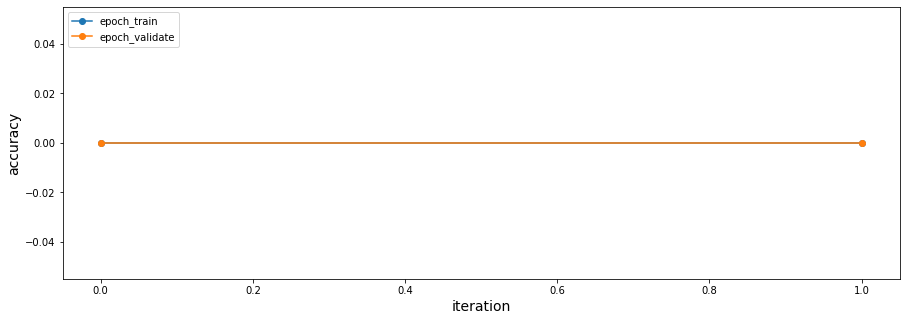

In [ ]:
model_name = 'TransformerClassifierFC'

m_trans = TransformerTransferClassifier(num_classes=len(class_names), retrain_last_encoder=False)
m_trans = m_trans.to(device)
optimizer = optim.SGD(m_trans.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_trans = train_model(m_trans, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_trans[key] for key in ['epoch_train', 'epoch_validate']})

# save to file
# MODEL
torch.save(m_trans.state_dict(), model_path + f'{model_name}.pt')
# RESULTS
filename = f'acc_{model_name}.csv'
epoch_results = pd.DataFrame({key: torch.Tensor(acc_trans[key]) for key in ['epoch_train', 'epoch_validate']})
epoch_results.to_csv(results_path + filename)

### Summarize transfer learning of last fully-connected layer

In [ ]:
key = 'epoch_validate'
transfer_resultsfc = {
    'resnetfc': max(acc_res[key]),
    'convnextfc': max(acc_convnext[key]),
    'transformerfc':max(acc_trans[key])
}
transfer_resultsfc

{'convnextfc': tensor(0.1538, dtype=torch.float64),
 'resnetfc': tensor(0.0769, dtype=torch.float64),
 'transformerfc': tensor(0., dtype=torch.float64)}

In [ ]:
# git saver
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'simple train of all baseline and transfer models'
!git push

/content/drive/My Drive /git/tree-finder
tcmalloc: large alloc 2408579072 bytes == 0x5591c72ae000 @  0x7fb8d7a901e7 0x5591c4dd0c35 0x5591c4dd0ced 0x5591c4d526fd 0x5591c4d5434e 0x5591c4d54673 0x5591c4da5cb8 0x5591c4da5dcc 0x5591c4da607c 0x5591c4d15bf5 0x5591c4de0bcb 0x5591c4d196d5 0x5591c4d3feda 0x5591c4d4010d 0x5591c4d98fb7 0x5591c4c6f6bc 0x5591c4c51a65 0x5591c4c52725 0x5591c4c5172a 0x7fb8d6dd7c87 0x5591c4c5177a
[main 4facc05] simple train of all baseline and transfer models
 3 files changed, 3 insertions(+), 3 deletions(-)
 rewrite models/TwoLayerFC.pt (87%)
Counting objects: 33, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (31/31), done.
error: RPC failed; curl 55 Failed sending data to the peer
fatal: The remote end hung up unexpectedly
Writing objects: 100% (33/33), 2.84 GiB | 40.23 MiB/s, done.
Total 33 (delta 11), reused 1 (delta 0)
fatal: The remote end hung up unexpectedly
Everything up-to-date


In [ ]:
!git add .
! git commit -m 'remove models, save train_species'
! git push


[main d714a0c] remove models, save train_species
 13 files changed, 30 insertions(+), 14 deletions(-)
 rewrite notebooks/preprocess_images.ipynb (67%)
 rewrite notebooks/train_species_classifiers.ipynb (95%)
 create mode 100644 results/acc_ConvNextClassifierFC.csv
 create mode 100644 results/acc_HingeClassifier.csv
 create mode 100644 results/acc_ResnetClassifierFC.csv
 create mode 100644 results/acc_SoftmaxClassifier.csv
 create mode 100644 results/acc_ThreeLayerCNN.csv
 create mode 100644 results/acc_TransformerClassifierFC.csv
 create mode 100644 results/acc_TwoLayerFC.csv
 delete mode 100644 results/acc_resnetbinclassifier.csv
Counting objects: 17, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (16/16), done.
Writing objects: 100% (17/17), 877.48 KiB | 6.05 MiB/s, done.
Total 17 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/etrieschman/tree-finder
   a567acf..d714a0c  main -> main
